100%|██████████| 188/188 [00:00<00:00, 46944.64it/s]


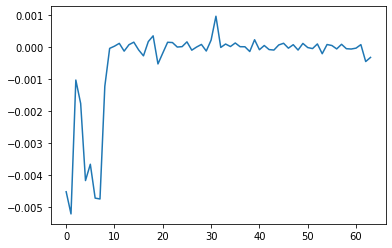

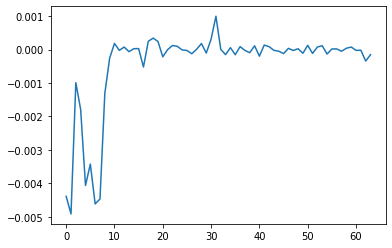

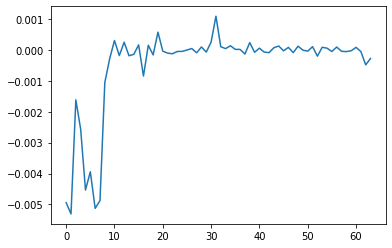

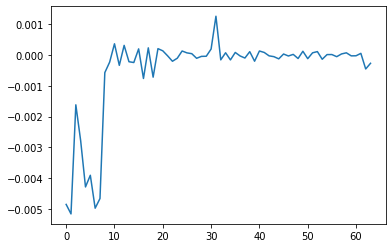

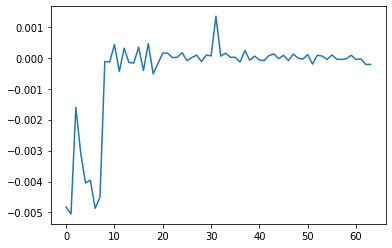

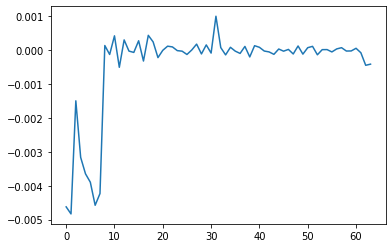

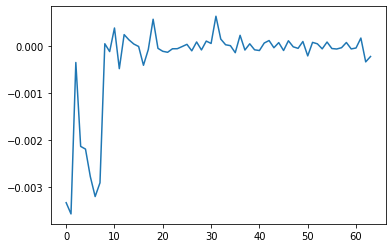

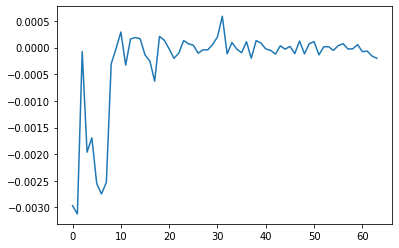

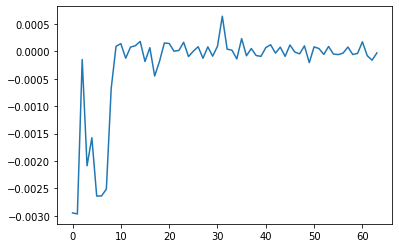

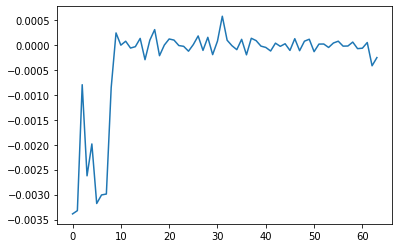

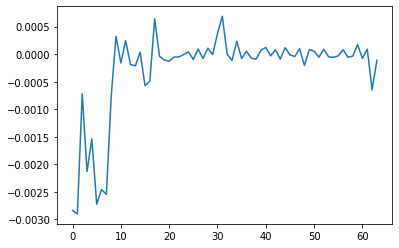

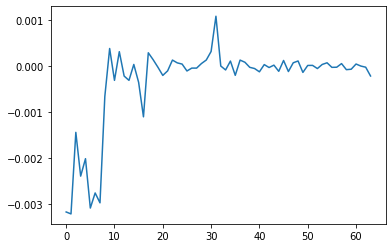

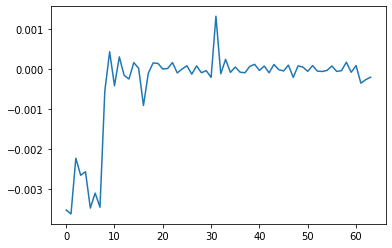

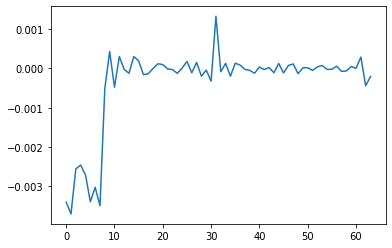

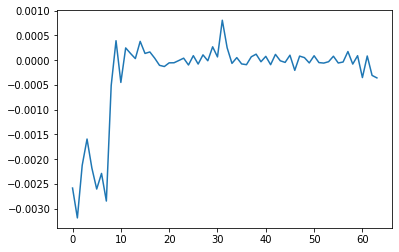

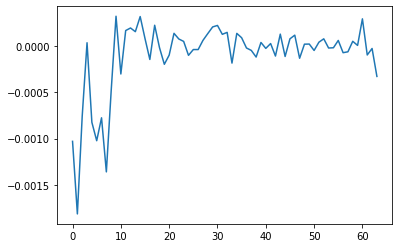

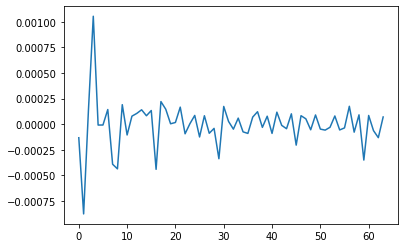

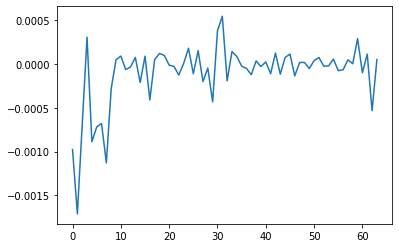

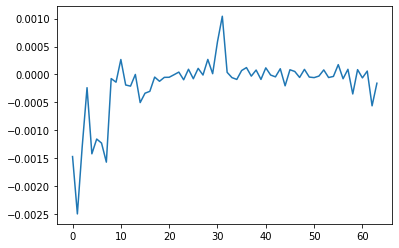

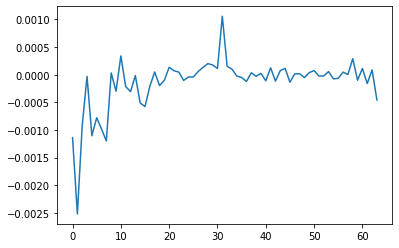

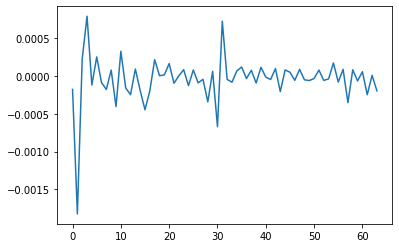

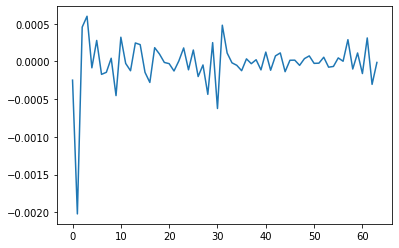

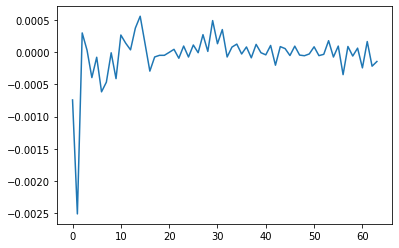

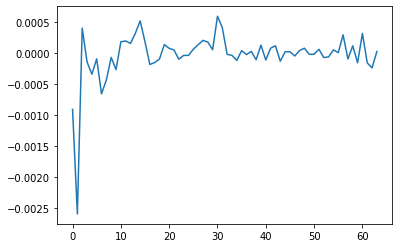

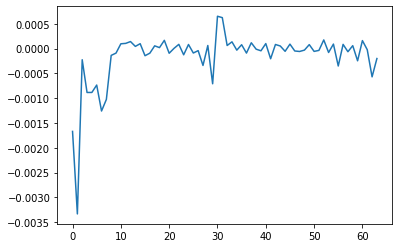

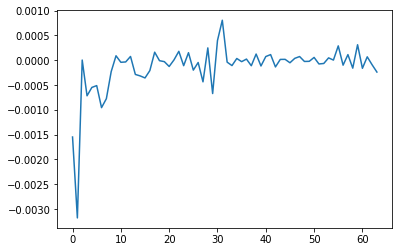

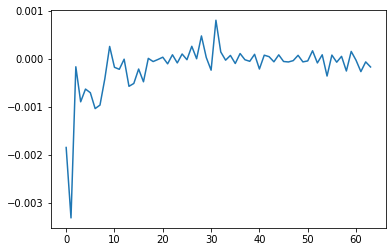

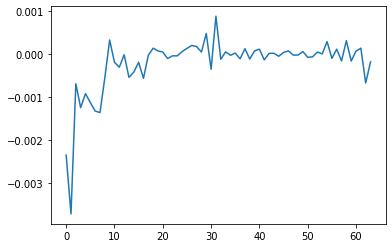

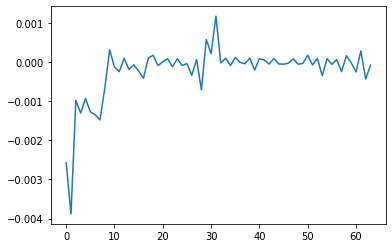

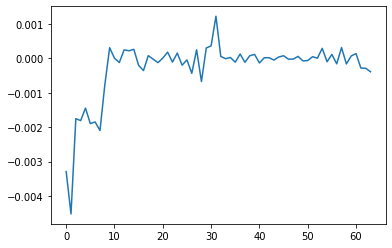

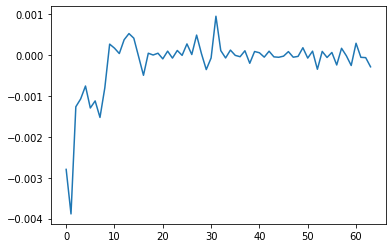

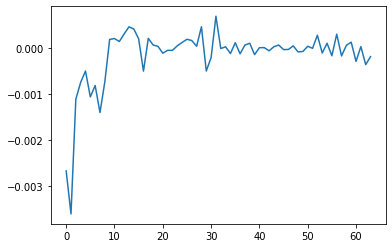

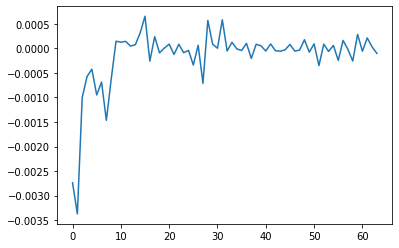

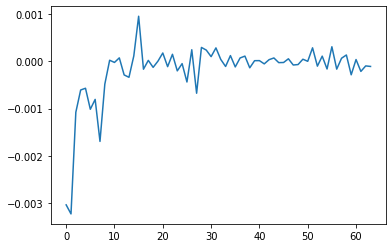

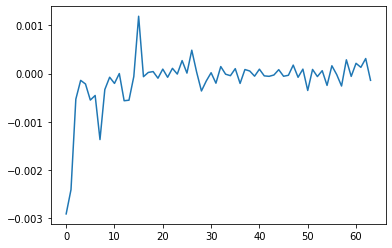

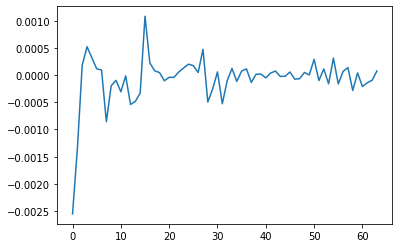

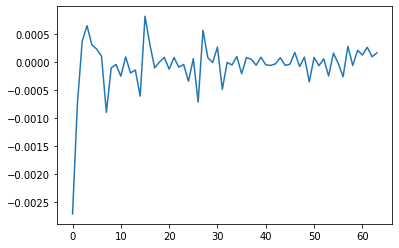

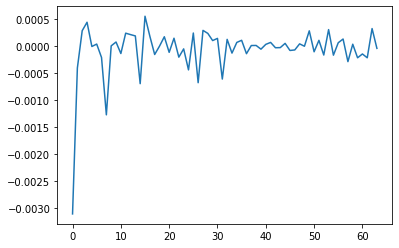

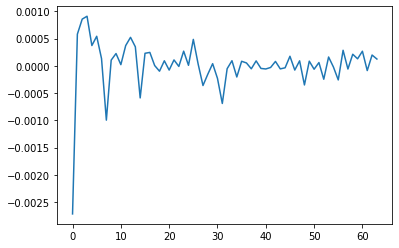

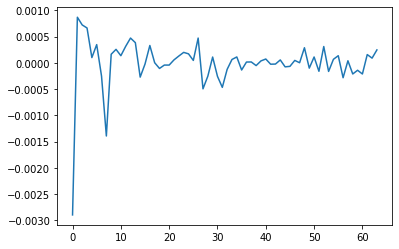

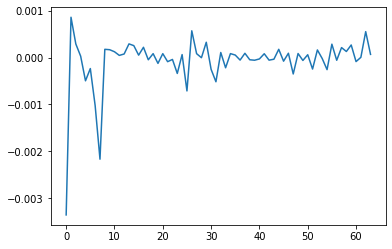

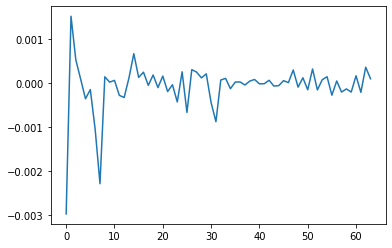

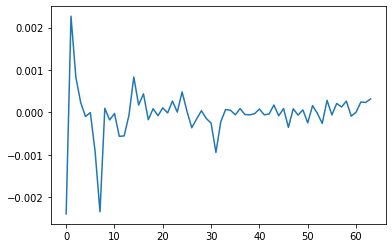

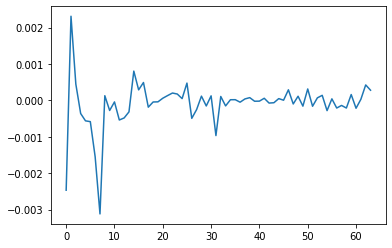

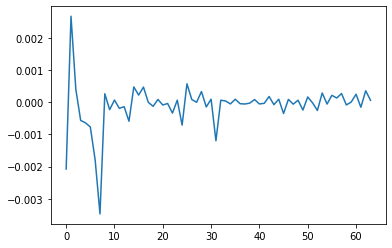

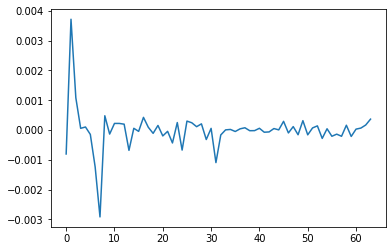

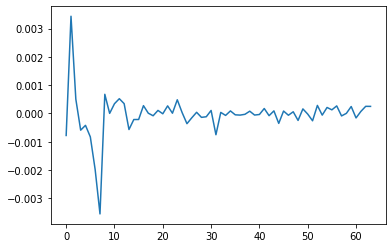

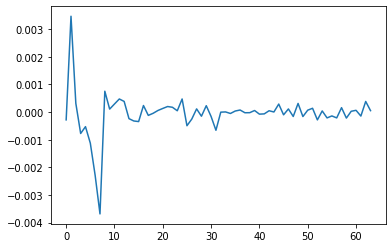

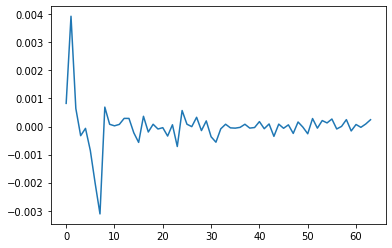

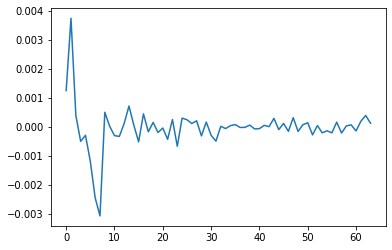

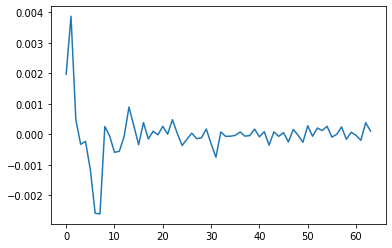

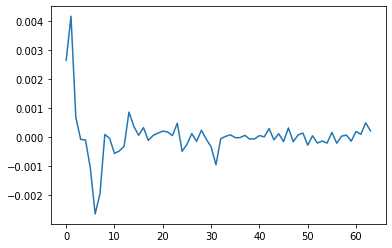

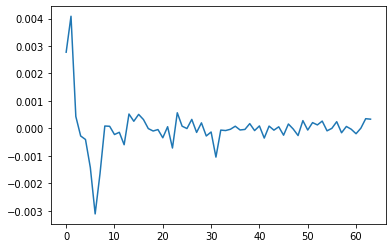

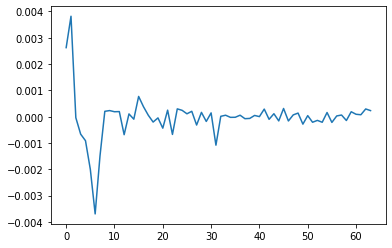

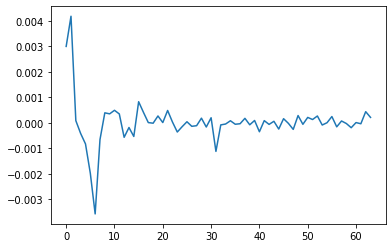

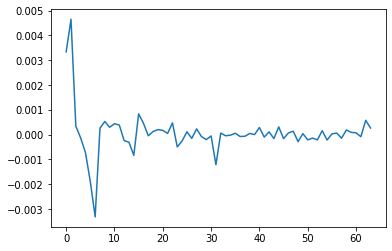

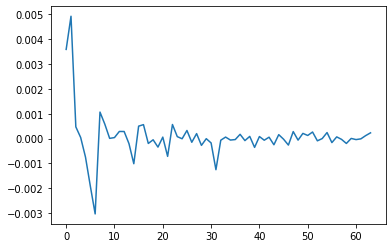

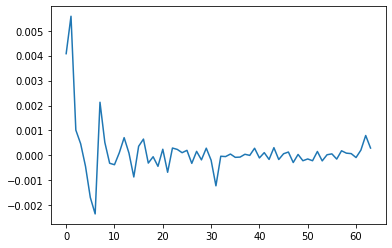

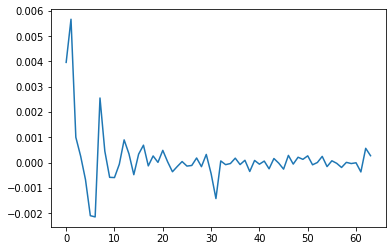

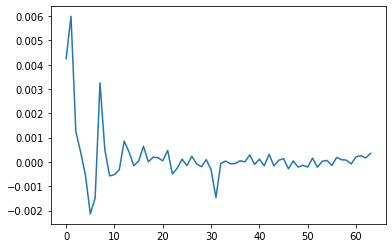

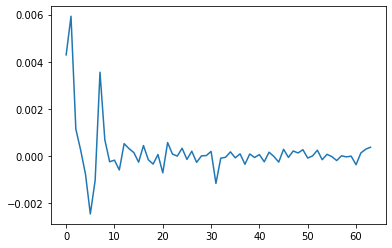

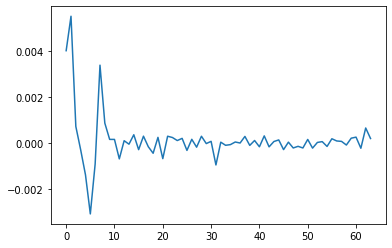

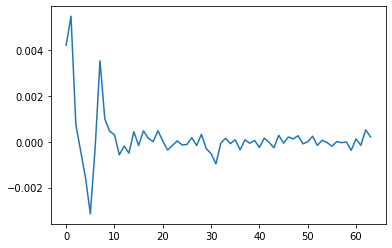

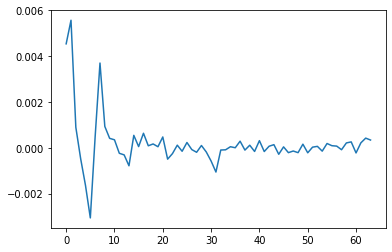

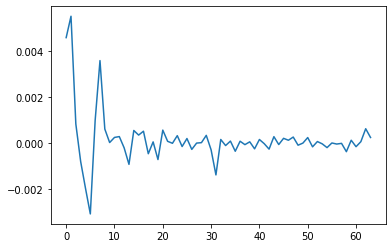

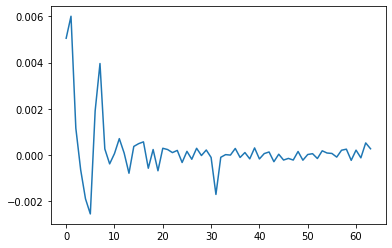

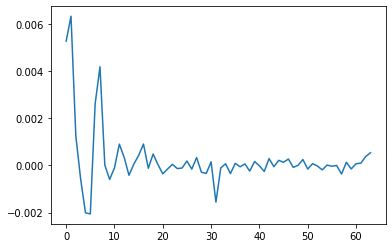

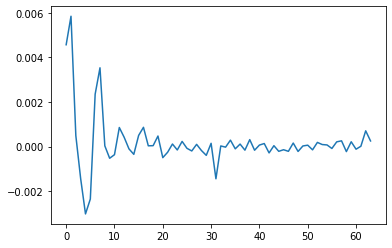

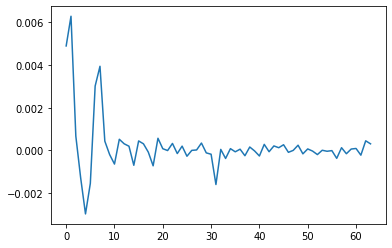

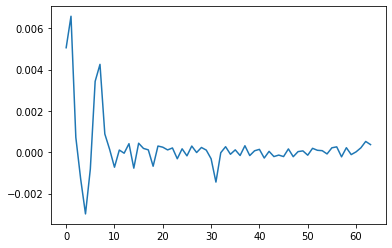

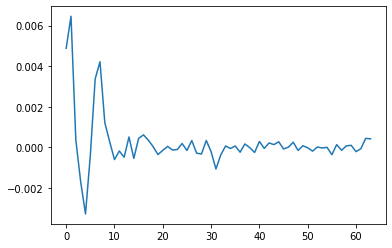

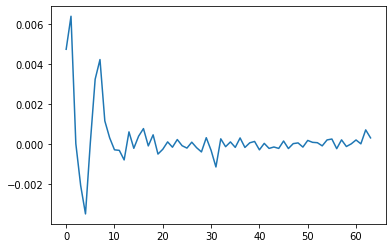

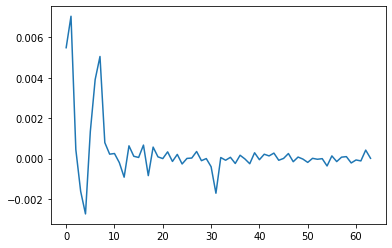

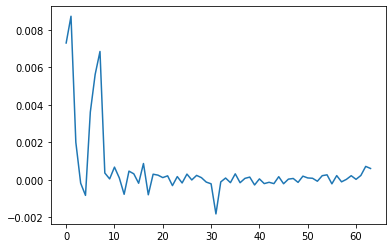

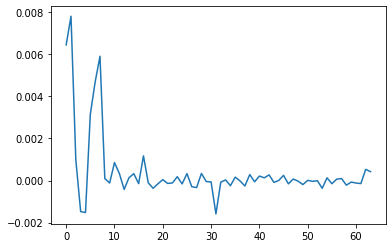

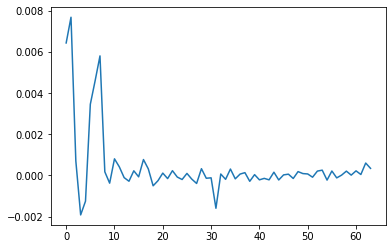

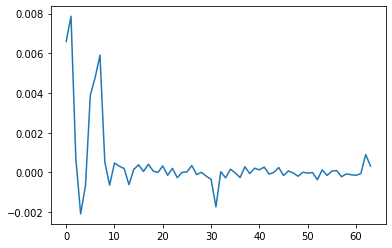

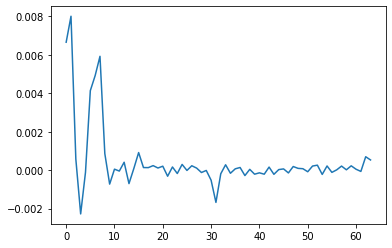

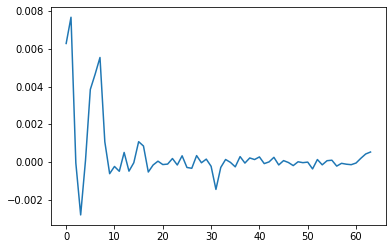

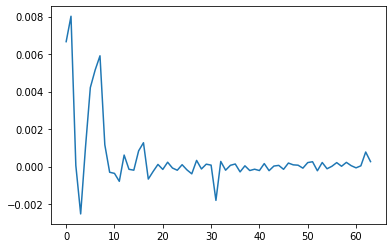

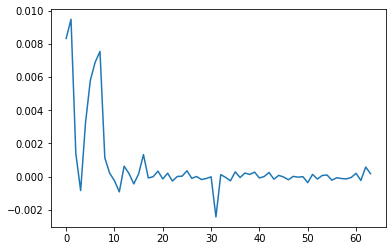

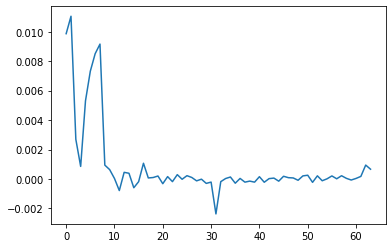

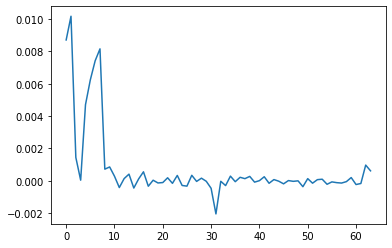

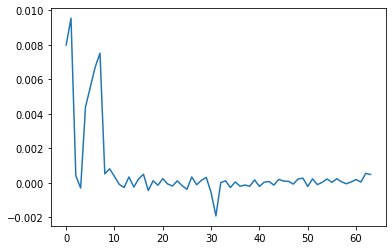

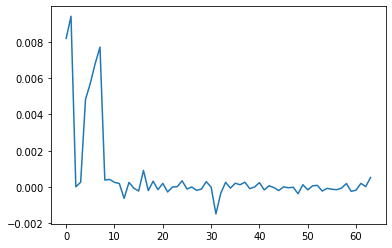

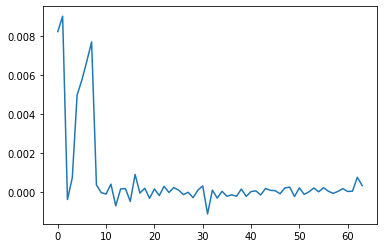

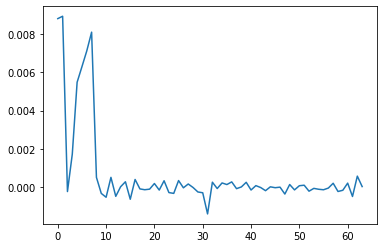

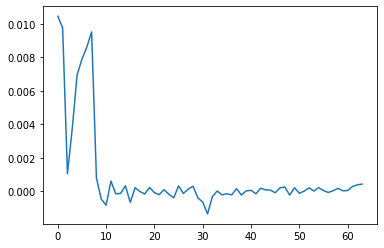

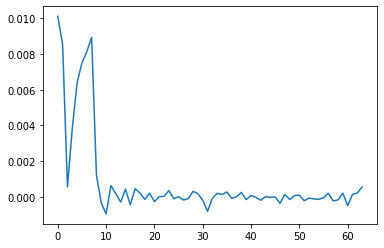

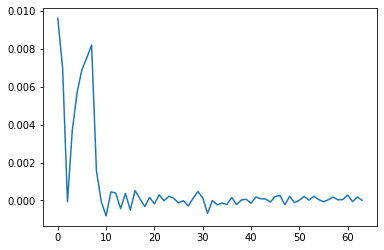

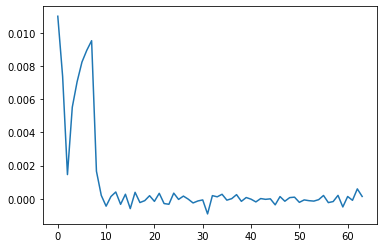

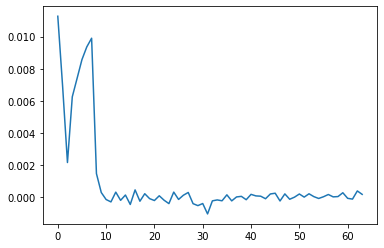

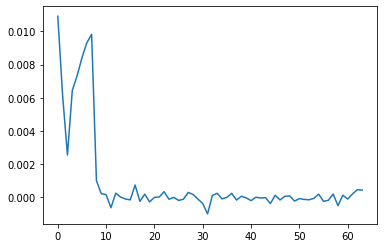

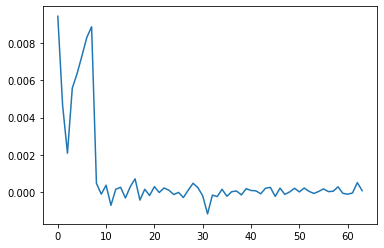

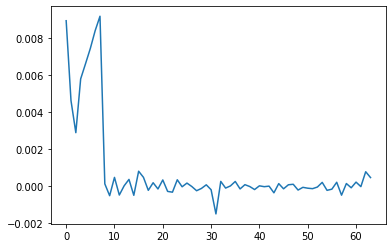

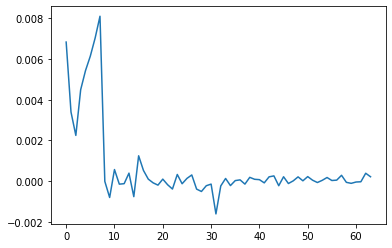

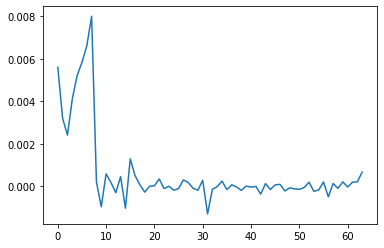

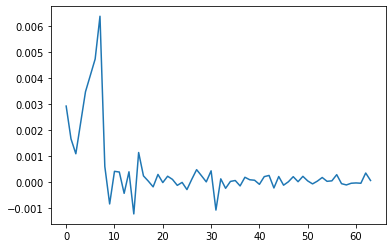

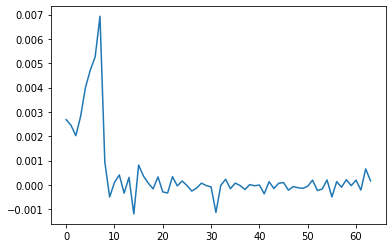

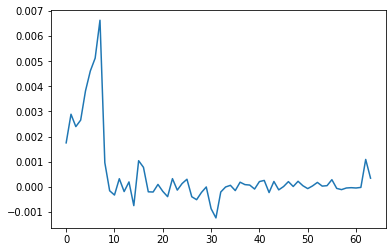

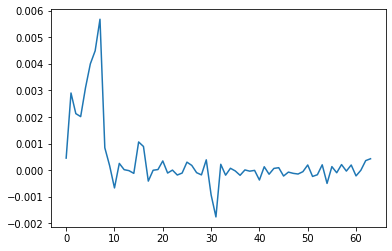

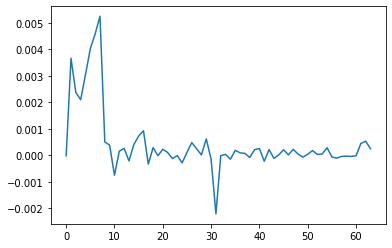

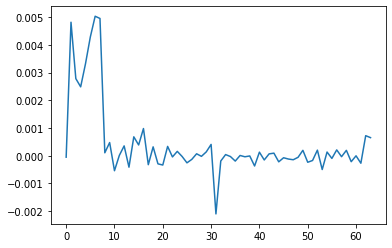

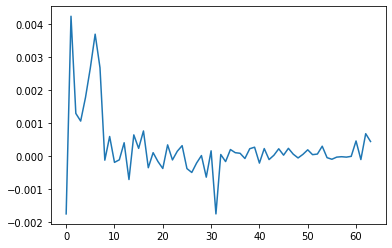

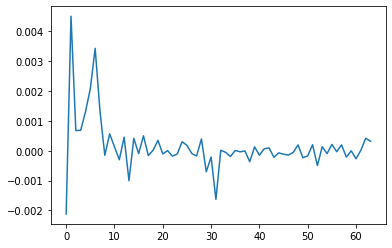

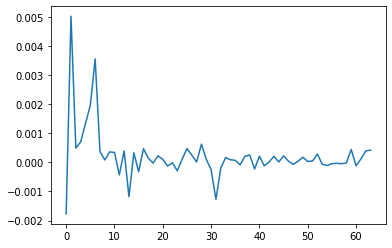

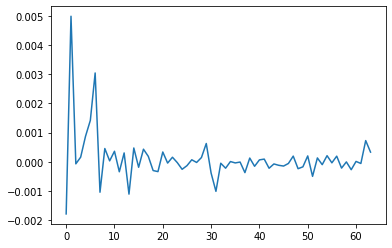

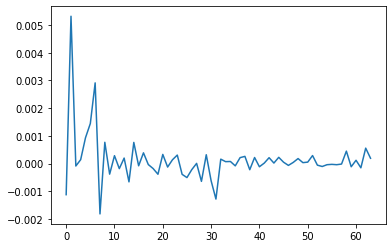

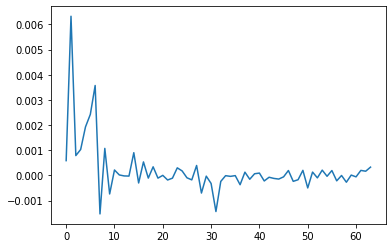

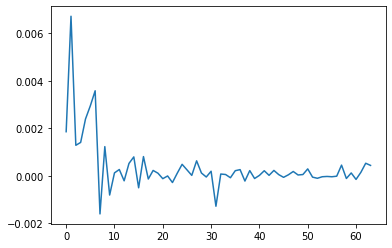

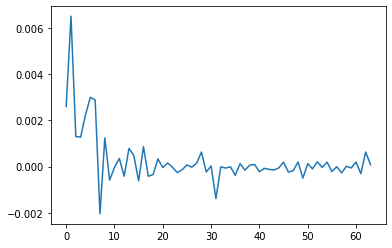

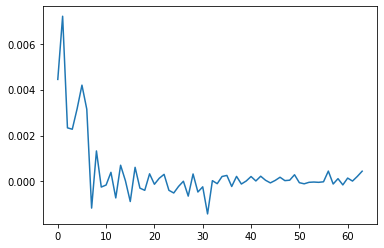

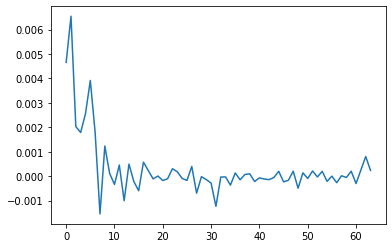

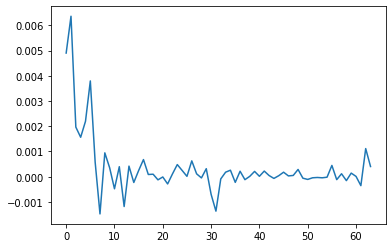

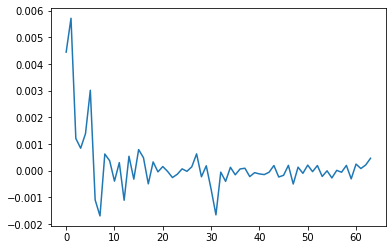

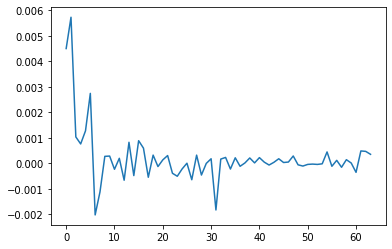

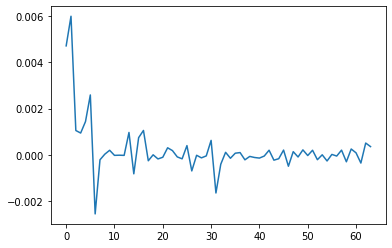

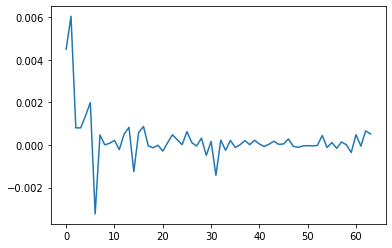

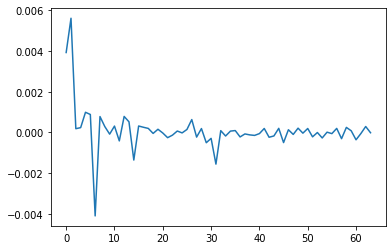

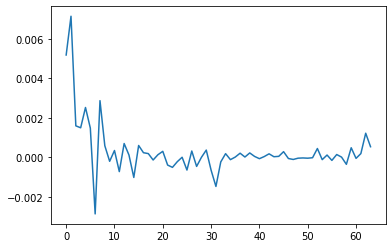

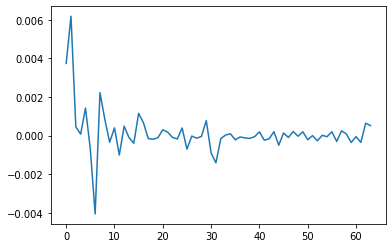

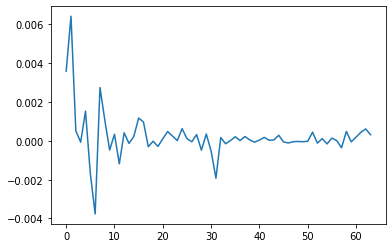

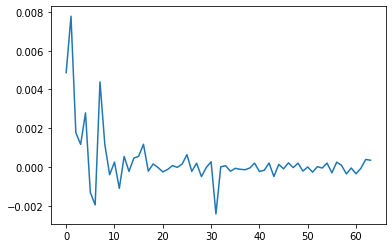

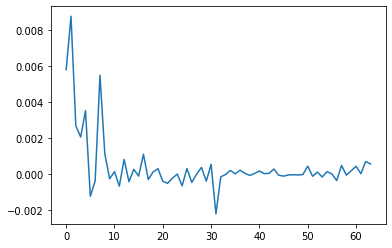

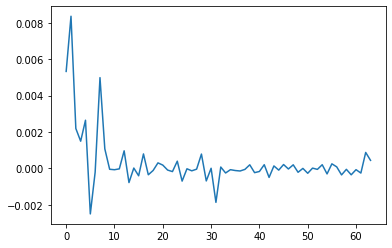

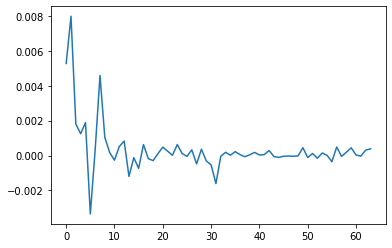

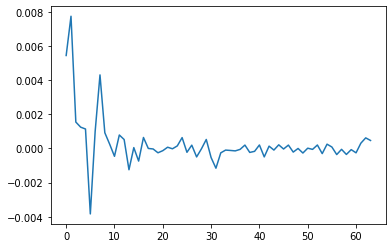

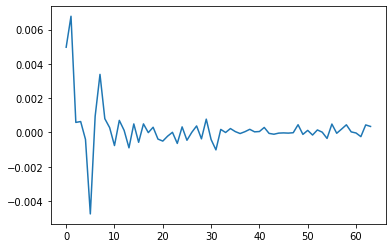

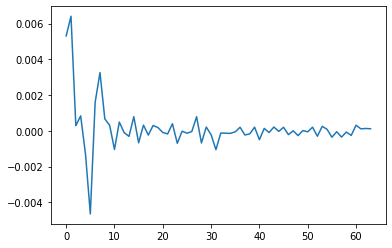

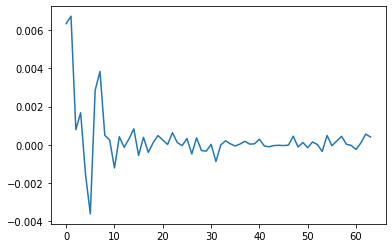

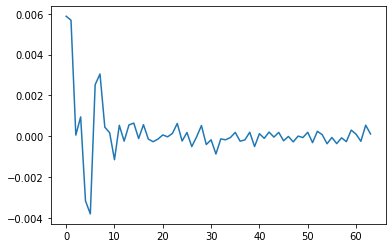

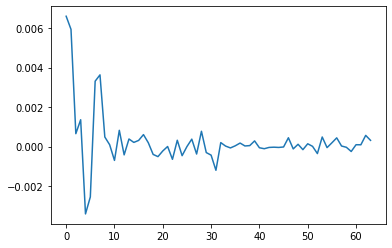

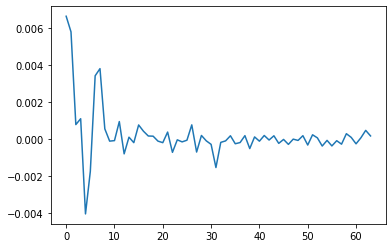

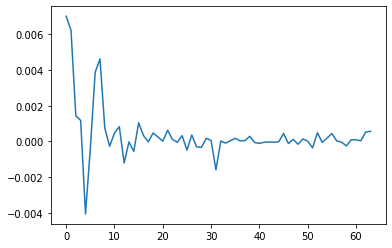

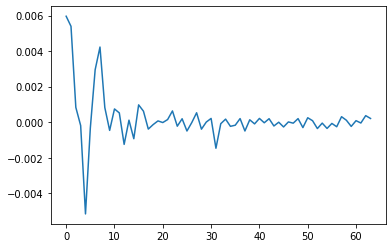

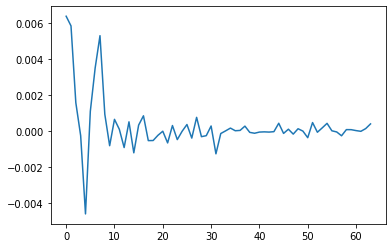

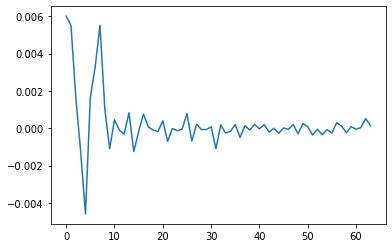

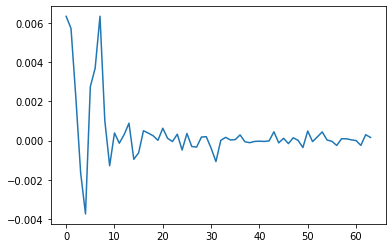

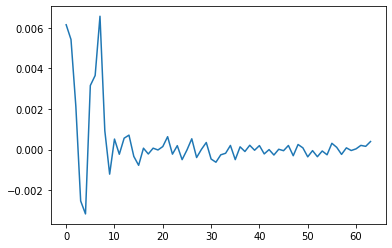

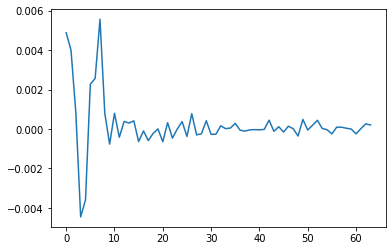

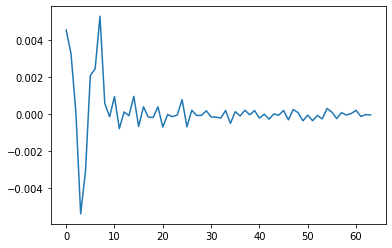

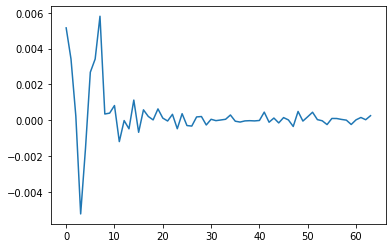

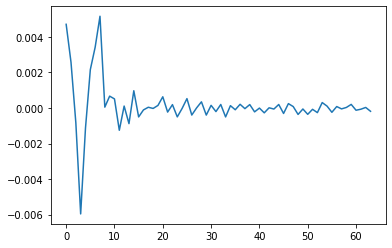

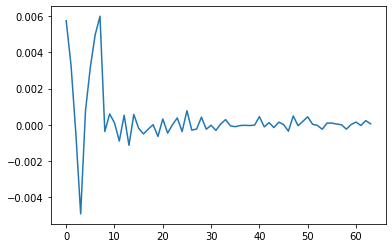

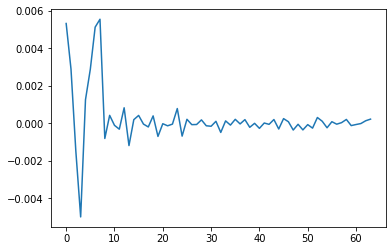

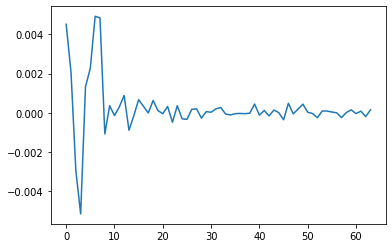

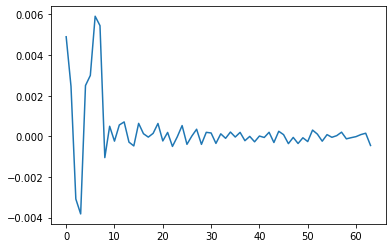

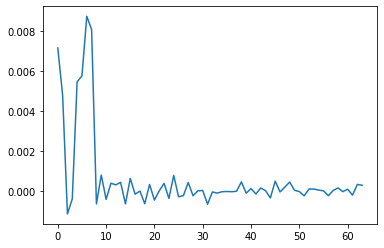

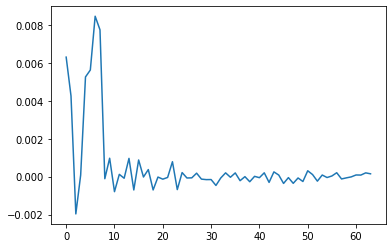

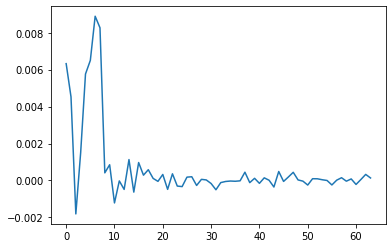

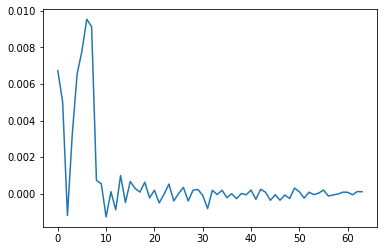

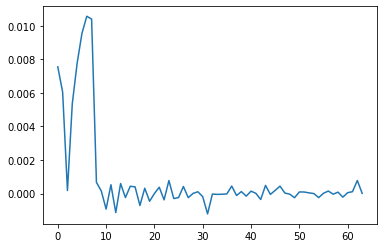

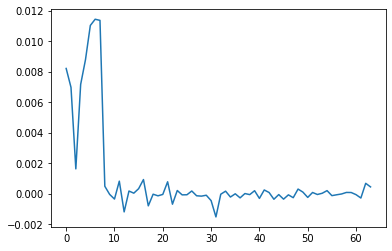

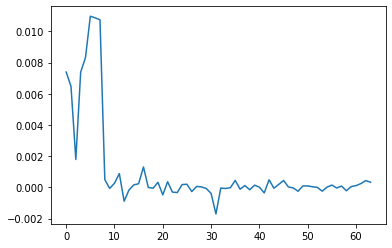

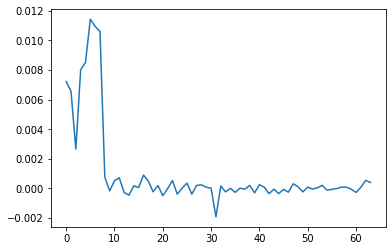

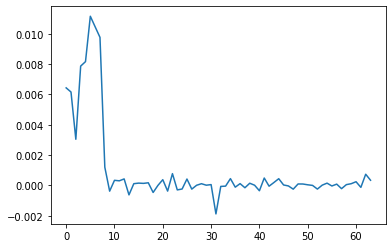

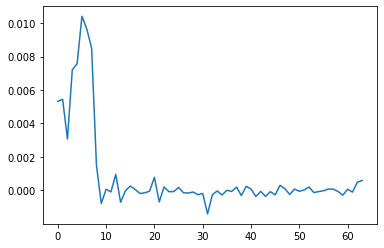

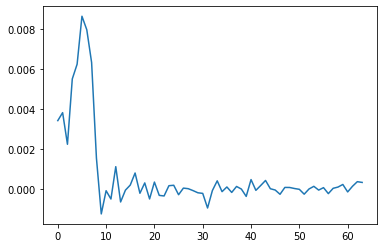

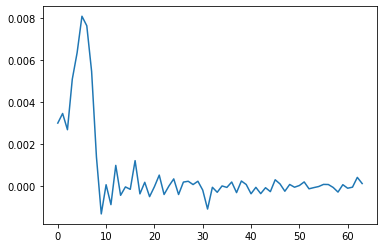

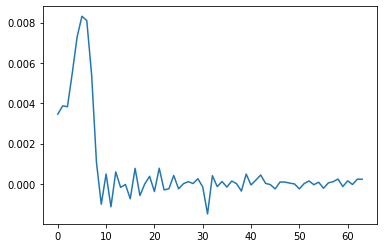

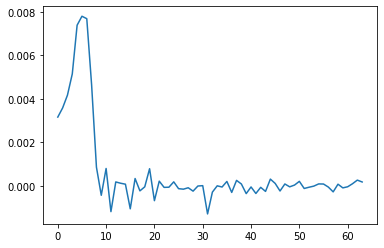

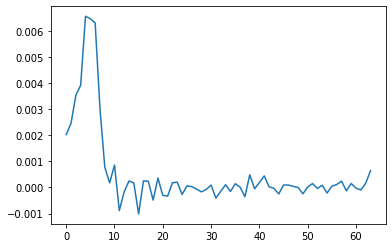

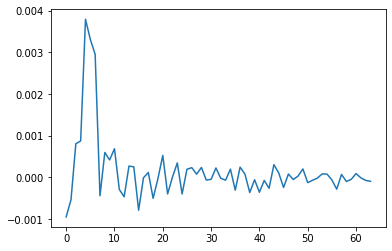

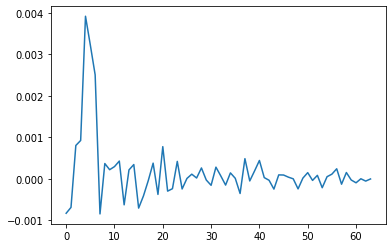

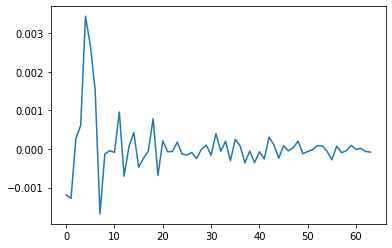

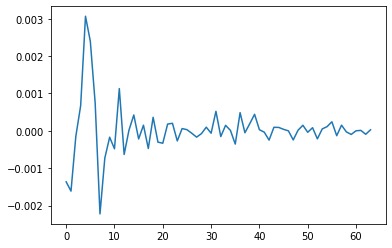

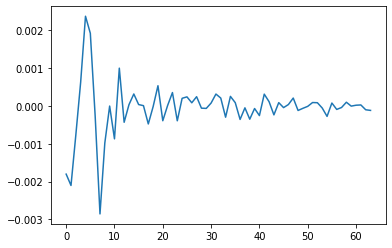

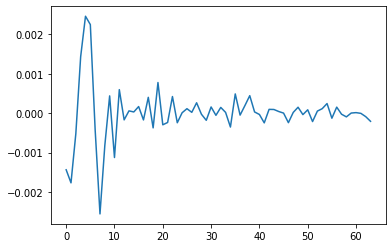

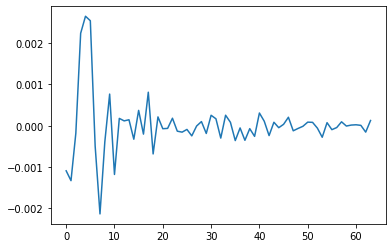

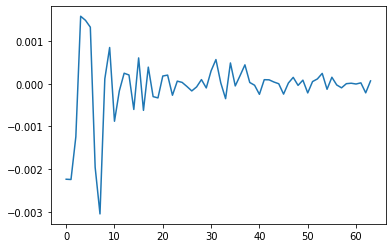

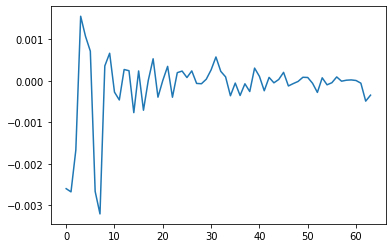

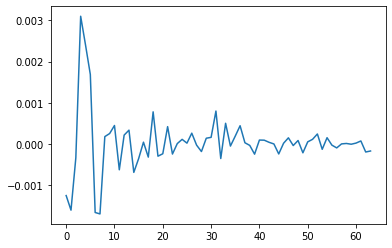

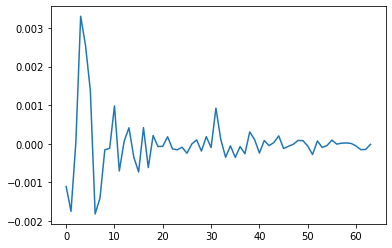

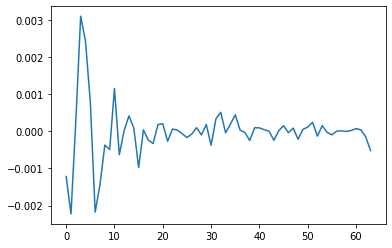

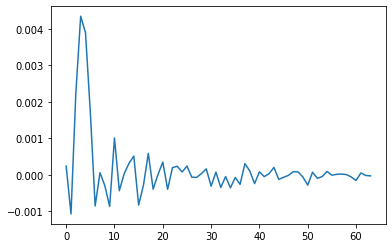

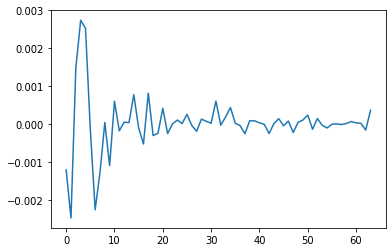

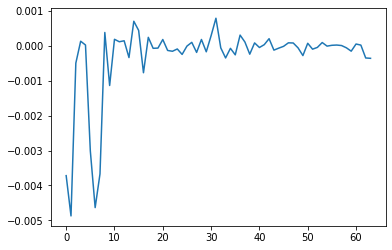

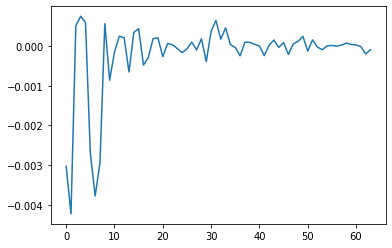

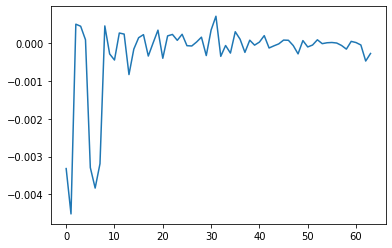

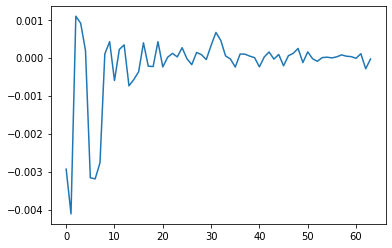

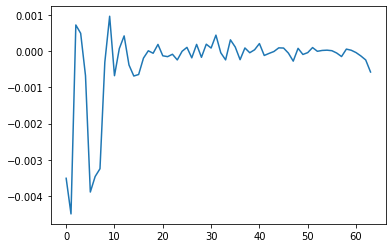

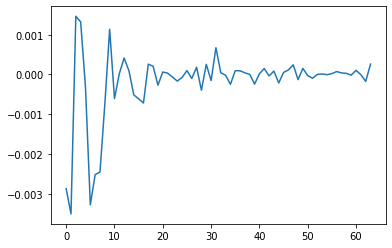

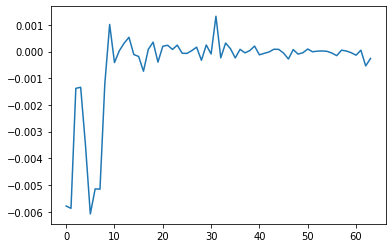

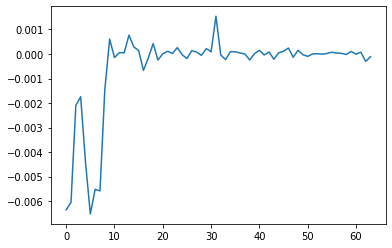

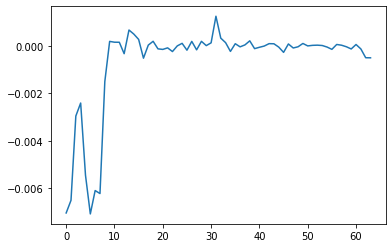

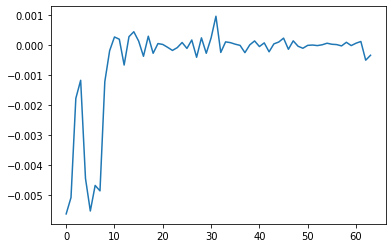

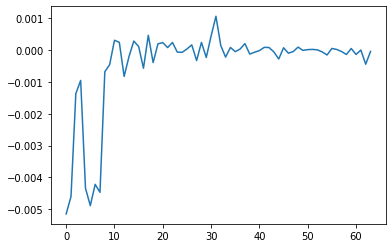

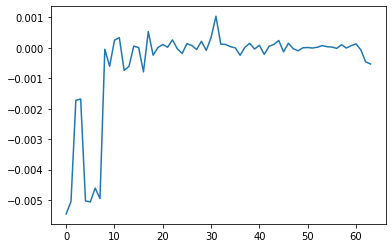

In [42]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

def roll(a, size, dx=1):
    shape = a.shape[:-1] + (int((a.shape[-1] - size) / dx) + 1, size)
    strides = a.strides + (a.strides[-1] * dx,)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


def embed(v, min_v, max_v, dim):
    """Возвращает бинарный вектор, длины dim"""
    step_size = dim / (max_v - min_v)
    v = max(min_v, min(max_v - 0.000001, v))
    n = int((v - min_v) * step_size)
    # result = np.zeros(dim, dtype="float32")
    result = np.full(dim, 0, dtype="float32")
    result[n] = 1
    return result


def unembed(n: int, min_v: float, max_v: float, dim: int) -> float:
    step_size = float((max_v - min_v) / dim)
    v = min_v + n * step_size
    return v

def load_dataset(tsv_file, count=1000, skip=0):
    stride = 1  # шаг "нарезки" входных данных
    in_shape = (64,1)
    out_shape = (8,)
    forward = 4
    data = pd.read_csv(
        tsv_file,
        sep="\t",
        header=0,
        dtype={
            "open": np.float32,
            "close": np.float32,
            "tickvol": np.float32,
            "vol": np.float32,
        },
        names=[
            "date",
            "time",
            "open",
            "high",
            "low",
            "close",
            "tickvol",
            "vol",
            "spread",
        ],
    )
    if skip > len(data.index):
        print(f"Число skip больше числа строк данных: {skip}>{len(data.index)}")
        return None, None
    if count + skip > len(data.index):
        count = len(data.index) - skip
    if skip == 0 and count == 0:
        open_rates = data["open"]
        vol_rates = data["tickvol"]
    elif skip == 0:
        open_rates = data["open"][-count:]
        vol_rates = data["tickvol"][-count:]
    elif count == 0:
        open_rates = data["open"][:-skip]
        vol_rates = data["tickvol"][:-skip]
    else:
        open_rates = data["open"][-count - skip : -skip]
        vol_rates = data["tickvol"][-count - skip : -skip]
    # объемы
    volumes = np.nan_to_num(np.array(vol_rates))
    volumes_strided = roll(volumes[:-forward], in_shape[0], stride)
    # цены
    prices = np.nan_to_num(np.array(open_rates), posinf=0, neginf=0)
    prices_strided = roll(prices[:-forward], in_shape[0], stride)
    prices_diff = np.diff(prices)
    data_size = len(prices_strided)
    # будущие цены
    forward_prices = roll(prices_diff[in_shape[0] :], forward, stride).sum(axis=1)
    x_std = float(prices_strided.std())
    y_std = float(forward_prices.std())

    scales = range(1, in_shape[0] + 1)
    # оси x: (индекс примера, масштабирования, сигналы, каналы)
    x = np.ndarray(shape=(data_size - 1, in_shape[0]))
    for i in tqdm(range(data_size - 1)):
        x[i, :], _ = pywt.coeffs_to_array(pywt.wavedecn(prices_strided[i] - prices_strided[i][0], wavelet='db4', mode='per'))
    y = np.zeros((forward_prices.shape[0], out_shape[0]))
    for i in tqdm(range(y.shape[0])):
        y[i] = embed(forward_prices[i],-3*y_std,3*y_std,8)
    return x.astype("float32"), y.astype("float32")
    
x, y = load_dataset(tsv_file="datas/EURUSD_M5_20000103_20200710.csv",count=128,skip=0)
for i in range(len(x)):
    plt.plot(x[i])
    plt.show()

In [43]:

coeffs, slices = pywt.coeffs_to_array(pywt.wavedecn(np.random.random(64), wavelet='db4', mode='per'))
a = pywt.wavedecn(np.random.random(64), wavelet='db4', mode='per')
print(coeffs)
# print(len(coeffs))

[ 1.57889014  1.58132163  1.07289734  1.41218     1.42324957  1.5117856
  1.36499711  1.66913897  0.00353089  0.01459261 -0.3326462  -0.71317633
  0.30416317  0.20004402  0.5615714  -0.43452377  0.10060335  0.40477379
  0.29732288 -0.21972973 -0.39180232 -0.45583385  0.31876305 -0.12862951
 -0.48841646  0.38520039 -0.54070623 -0.22682543 -0.31108198 -0.07747662
  0.41739153  0.1905096  -0.30849485 -0.36078961 -0.33887856 -0.18180317
 -0.36183817  0.11435951  0.51812963  0.32353224  0.35989441  0.26148777
 -0.07693265  0.18829625 -0.03908634  0.30023969  0.1507266   0.19795289
  0.16617133 -0.01841576 -0.27497234  0.12359557  0.3628939  -0.25192169
  0.00268232 -0.26835229 -0.13484135  0.28093711 -0.05528811  0.42465901
  0.12411644  0.20035214  0.02660795 -0.14941471]
